In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator
from materialize import MZ_ROOT

In [2]:
# Set grid option globally
plt.rcParams["axes.grid"] = True

Read input file:

In [3]:
df = pd.read_csv(MZ_ROOT / "test" / "cluster-spec-sheet" / "results.csv")

Compute additional columns

In [4]:
# Remove the scale factor from the scenario name.
df["scenario_name"] = df["scenario"].map(lambda x: x.rsplit("_", 1)[0])
# Cluster replica size as credits/hour
df["credits_per_h"] = df["cluster_size"].str[:-2].astype(int) / 100
# Cluster replica size as centi-credits/s
df["ccredit_per_s"] = df["credits_per_h"] / 3600 * 100
# Number of timely workers
df["workers"] = round(df["credits_per_h"] * 1.9375)
# Throughput in MiB/s
df["throughput_mb_per_s"] = df["size_bytes"] / df["time_ms"] * 1000 / 1024 / 1024
# Throughput in MiB/s/worker
df["throughput_mb_per_s_worker"] = (
    df["size_bytes"] / 1024 / 1024 / df["time_ms"] * 1000 / df["workers"]
)
# Throughput in MiB/credit
df["throughput_mb_per_credit"] = (
    df["size_bytes"] / 1024 / 1024 / df["time_ms"] * 1000 / df["ccredit_per_s"]
)
# Cost in centi-credits: ccredit/s * s
df["credit_time"] = df["ccredit_per_s"] * df["time_ms"] / 1000.0

In [5]:
df

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
0,tpcc_sf_10,strong,arrangement_formation,create_index,100cc,0,7400783934,183450,tpcc_sf,1.0,0.027778,2.0,38.473358,19.236679,1.385041e+03,5.095833
1,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,0,7400789951,108,tpcc_sf,1.0,0.027778,2.0,65351.326828,32675.663414,2.352648e+06,0.003000
2,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,1,7400794025,107,tpcc_sf,1.0,0.027778,2.0,65962.123202,32981.061601,2.374636e+06,0.002972
3,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,2,7400797309,107,tpcc_sf,1.0,0.027778,2.0,65962.152472,32981.076236,2.374637e+06,0.002972
4,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,3,7400799776,107,tpcc_sf,1.0,0.027778,2.0,65962.174460,32981.087230,2.374638e+06,0.002972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,auction_1280,weak,primitive_operators,bids_sum,3200cc,0,42435253109,19565,auction,32.0,0.888889,62.0,2068.459545,33.362251,2.327017e+03,17.391111
578,auction_1280,weak,composite_operators,bids_count_max_sum_min,3200cc,0,42437171999,131700,auction,32.0,0.888889,62.0,307.298717,4.956431,3.457111e+02,117.066667
579,auction_1280,weak,primitive_operators,join,3200cc,0,42437412360,17378,auction,32.0,0.888889,62.0,2328.891140,37.562760,2.620003e+03,15.447111
580,auction_1280,weak,composite_operators,join_max,3200cc,0,42440405738,210865,auction,32.0,0.888889,62.0,191.944253,3.095875,2.159373e+02,187.435556


## Show properties of the data

In [6]:
df["scenario"].value_counts()

scenario
auction_40       210
tpcc_mv_sf_10    144
tpcc_sf_10        78
auction_80        30
auction_160       30
auction_320       30
auction_640       30
auction_1280      30
Name: count, dtype: int64

In [7]:
df["mode"].value_counts()

mode
strong    402
weak      180
Name: count, dtype: int64

In [8]:
df["category"].value_counts()

category
peek_serving                   474
arrangement_formation           36
primitive_operators             36
composite_operators             24
materialized_view_formation     12
Name: count, dtype: int64

In [9]:
df["test_name"].value_counts()

test_name
peek_index_key_fast_path                    180
peek_index_key_slow_path                    120
peek_materialized_view_key_slow_path         60
peek_materialized_view_key_fast_path         60
peek_index_non_key_fast_path                 18
index_restart                                18
join_max                                     12
bids_max                                     12
join                                         12
bids_count_max_sum_min                       12
bids_sum                                     12
create_index_primary_key                     12
create_index_foreign_key                     12
peek_index_non_key_slow_path                 12
create_index                                  6
peek_materialized_view_non_key_fast_path      6
peek_materialized_view_non_key_slow_path      6
create_materialize_view                       6
materialized_view_restart                     6
Name: count, dtype: int64

# Elapsed time

In [10]:
# df2 = df.query('test_name == "join"').pivot(index='credits_per_h', columns=['category', 'test_name', 'mode'], values='time_ms')
df2 = (
    df.query('category != "peek_serving"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["category", "test_name", "mode"],
        values=["time_ms"],
    )
    .sort_index(axis=1)
)
df2

time_ms                           \
category                    arrangement_formation                            
test_name                            create_index create_index_foreign_key   
mode                                       strong                   strong   
scenario_name credits_per_h                                                  
auction       1.0                             NaN                  40796.0   
              2.0                             NaN                  20464.0   
              4.0                             NaN                  10270.0   
              8.0                             NaN                   5288.0   
              16.0                            NaN                   2949.0   
              32.0                            NaN                   1718.0   
tpcc_mv_sf    1.0                             NaN                      NaN   
              2.0                             NaN                      NaN   
              4.0                             NaN                      NaN   
              8.0                             NaN                      NaN   
              16.0                            NaN                      NaN   
              32.0                            NaN                      NaN   
tpcc_sf       1.0                        183450.0                      NaN   
              2.0                         96806.0                      NaN   
              4.0                         57015.0                      NaN   
              8.0                         28397.0                      NaN   
              16.0                        22397.0                      NaN   
              32.0                        14780.0                      NaN   

                                                                        \
category                                                                 
test_name                            create_index_primary_key            
mode                            weak                   strong     weak   
scenario_name credits_per_h                                              
auction       1.0            41234.0                  39070.0  42130.0   
              2.0            40596.0                  24676.0  44173.0   
              4.0            41475.0                  16249.0  46440.0   
              8.0            42984.0                  10379.0  51306.0   
              16.0           46305.0                   9377.0  63343.0   
              32.0           51670.0                   5665.0  82199.0   
tpcc_mv_sf    1.0                NaN                      NaN      NaN   
              2.0                NaN                      NaN      NaN   
              4.0                NaN                      NaN      NaN   
              8.0                NaN                      NaN      NaN   
              16.0               NaN                      NaN      NaN   
              32.0               NaN                      NaN      NaN   
tpcc_sf       1.0                NaN                      NaN      NaN   
              2.0                NaN                      NaN      NaN   
              4.0                NaN                      NaN      NaN   
              8.0                NaN                      NaN      NaN   
              16.0               NaN                      NaN      NaN   
              32.0               NaN                      NaN      NaN   

                                                                            \
category                                     composite_operators             
test_name                   index_restart bids_count_max_sum_min             
mode                               strong                 strong      weak   
scenario_name credits_per_h                                                  
auction       1.0                     NaN               146544.0  149073.0   
              2.0                     NaN                78954.0  130374.0  

## TPC-h
Creating an index, restarting replica

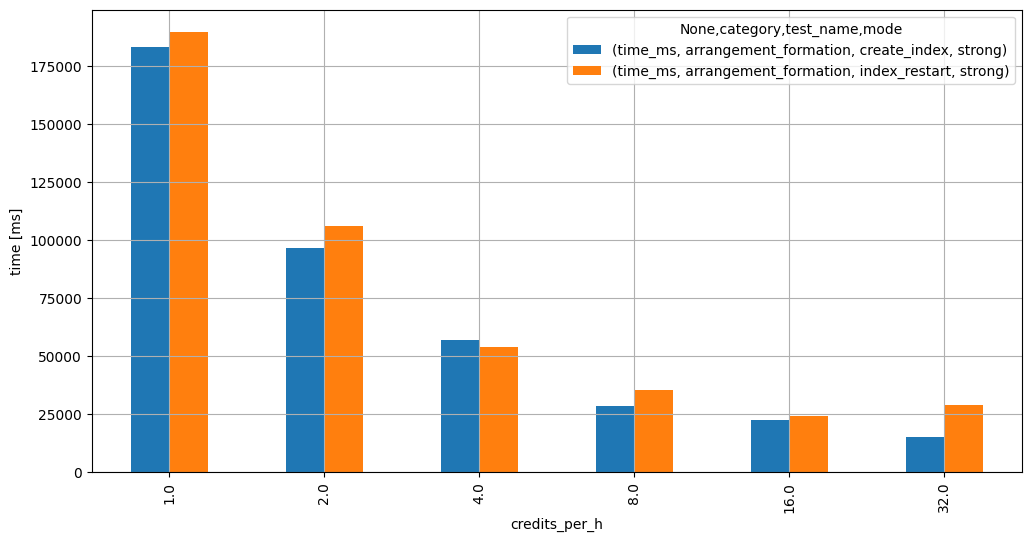

In [11]:
ax = (
    df2.loc["tpcc_sf"]
    .dropna(axis=1, how="all")
    .plot(kind="bar", figsize=(12, 6), ylabel="time [ms]", logy=False)
)

## TPC-h MV
Creating materialized view, restarting replica

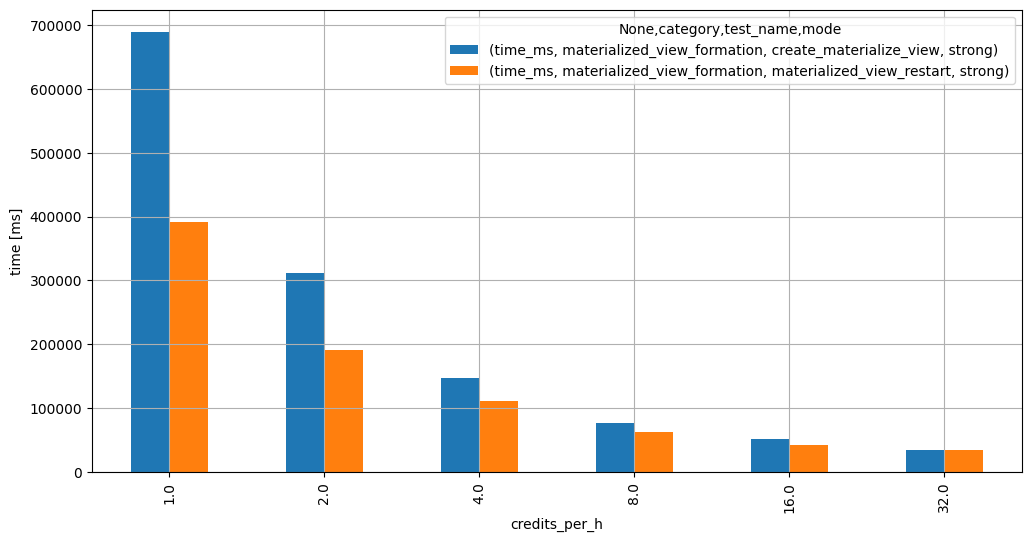

In [12]:
ax = (
    df2.loc["tpcc_mv_sf"]
    .dropna(axis=1, how="all")
    .plot(kind="bar", figsize=(12, 6), ylabel="time [ms]", logy=False)
)

## Auction load generator (MV-based)
### Creating an index
* Primary key: from materialized view
* Foreign key: from primary key

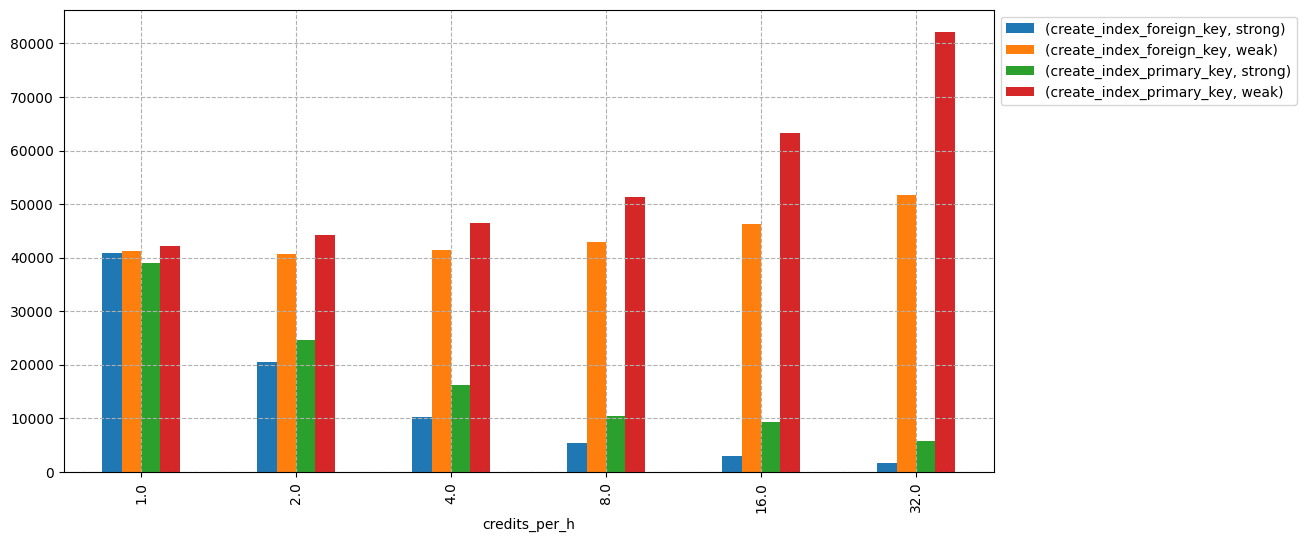

In [13]:
ax = (
    df2.loc[("auction",), ("time_ms", "arrangement_formation")]
    .dropna(axis=1, how="all")
    .plot(kind="bar", logy=False, figsize=(12, 6))
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
# ax.set_ylim(1000)
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))
# ax.yaxis.set_minor_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))
# ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=3))
ax.grid(which="both", linestyle="--")

# Credit time
In the following, we analyze scenarios by credit time, which is the product of a replica's credit consumption times the time a test took. The value is centi-credits.

In [14]:
#  and mode == "strong"
df2 = (
    df.query('category != "peek_serving"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["category", "test_name", "mode"],
        values=["credit_time"],
    )
    .sort_index(axis=1)
)
df2

credit_time                           \
category                    arrangement_formation                            
test_name                            create_index create_index_foreign_key   
mode                                       strong                   strong   
scenario_name credits_per_h                                                  
auction       1.0                             NaN                 1.133222   
              2.0                             NaN                 1.136889   
              4.0                             NaN                 1.141111   
              8.0                             NaN                 1.175111   
              16.0                            NaN                 1.310667   
              32.0                            NaN                 1.527111   
tpcc_mv_sf    1.0                             NaN                      NaN   
              2.0                             NaN                      NaN   
              4.0                             NaN                      NaN   
              8.0                             NaN                      NaN   
              16.0                            NaN                      NaN   
              32.0                            NaN                      NaN   
tpcc_sf       1.0                        5.095833                      NaN   
              2.0                        5.378111                      NaN   
              4.0                        6.335000                      NaN   
              8.0                        6.310444                      NaN   
              16.0                       9.954222                      NaN   
              32.0                      13.137778                      NaN   

                                                                            \
category                                                                     
test_name                              create_index_primary_key              
mode                              weak                   strong       weak   
scenario_name credits_per_h                                                  
auction       1.0             1.145389                 1.085278   1.170278   
              2.0             2.255333                 1.370889   2.454056   
              4.0             4.608333                 1.805444   5.160000   
              8.0             9.552000                 2.306444  11.401333   
              16.0           20.580000                 4.167556  28.152444   
              32.0           45.928889                 5.035556  73.065778   
tpcc_mv_sf    1.0                  NaN                      NaN        NaN   
              2.0                  NaN                      NaN        NaN   
              4.0                  NaN                      NaN        NaN   
              8.0                  NaN                      NaN        NaN   
              16.0                 NaN                      NaN        NaN   
              32.0                 NaN                      NaN        NaN   
tpcc_sf       1.0                  NaN                      NaN        NaN   
              2.0                  NaN                      NaN        NaN   
              4.0                  NaN                      NaN        NaN   
              8.0                  NaN                      NaN        NaN   
              16.0                 NaN                      NaN        NaN   
              32.0                 NaN                      NaN        NaN   

                                                                              \
category                                     composite_operators               
test_name                   index_restart bids_count_max_sum_min               
mode                               strong                 strong        weak   
scenario_name credits_per_h                                                    
auction       1.0                     NaN       

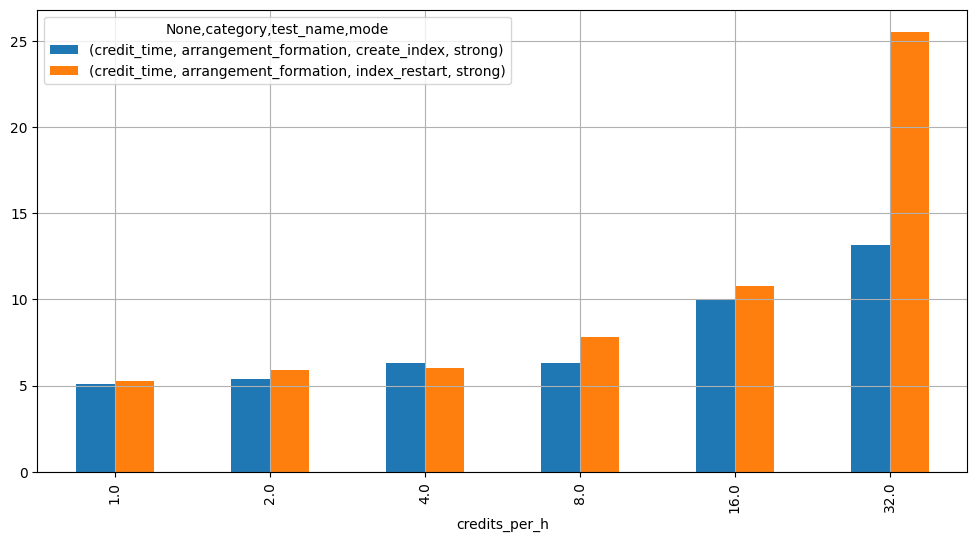

In [15]:
ax = df2.loc["tpcc_sf"].dropna(axis=1, how="all").plot(kind="bar", figsize=(12, 6))

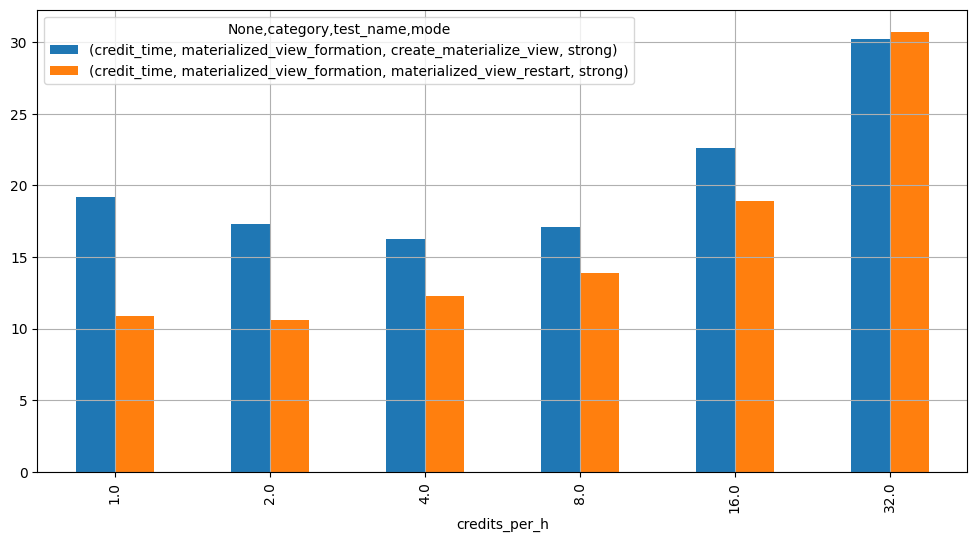

In [16]:
ax = df2.loc["tpcc_mv_sf"].dropna(axis=1, how="all").plot(kind="bar", figsize=(12, 6))

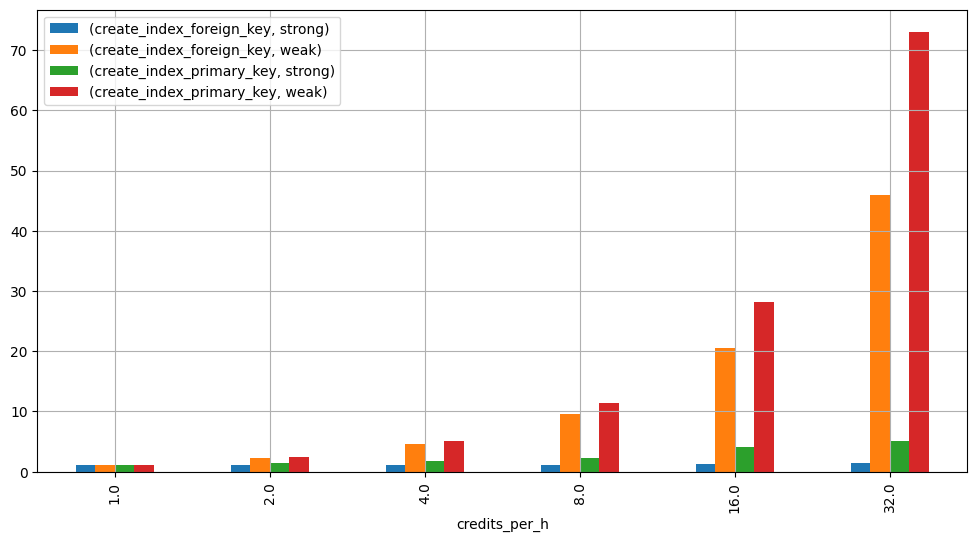

In [17]:
ax = (
    df2.loc[("auction",), ("credit_time", "arrangement_formation")]
    .dropna(axis=1, how="all")
    .plot(kind="bar", logy=False, figsize=(12, 6))
)
ax.legend(loc="upper left", bbox_to_anchor=(0, 1))

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
222,auction_40,strong,arrangement_formation,create_index_primary_key,100cc,0,1464660863,39070,auction,1.0,0.027778,2.0,35.751458,17.875729,1287.052473,1.085278
252,auction_40,strong,arrangement_formation,create_index_primary_key,200cc,0,1464204382,24676,auction,2.0,0.055556,4.0,56.588350,14.147087,1018.590292,1.370889
282,auction_40,strong,arrangement_formation,create_index_primary_key,400cc,0,1463323357,16249,auction,4.0,0.111111,8.0,85.884295,10.735537,772.958651,1.805444
312,auction_40,strong,arrangement_formation,create_index_primary_key,800cc,0,1460673449,10379,auction,8.0,0.222222,16.0,134.213966,8.388373,603.962847,2.306444
342,auction_40,strong,arrangement_formation,create_index_primary_key,1600cc,0,1454733967,9377,auction,16.0,0.444444,31.0,147.951629,4.772633,332.891164,4.167556
372,auction_40,strong,arrangement_formation,create_index_primary_key,3200cc,0,1454584117,5665,auction,32.0,0.888889,62.0,244.871935,3.949547,275.480927,5.035556


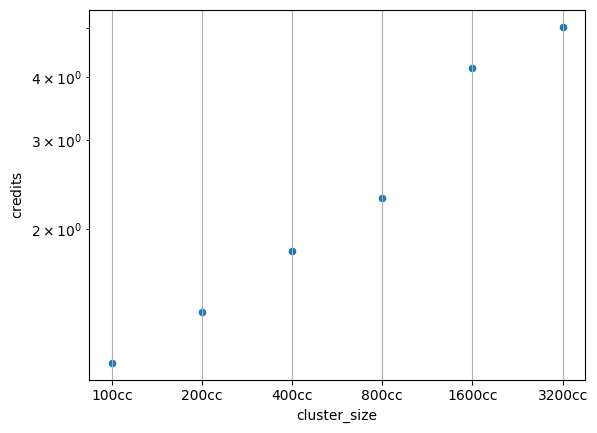

In [18]:
df2 = df[(df["mode"] == "strong") & (df["test_name"] == "create_index_primary_key")]
df2.plot(
    kind="scatter",
    x="cluster_size",
    y="credit_time",
    ylabel="$\\text{credits}$",
    logy=True,
    grid=True,
)
df2

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
78,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,100cc,0,0,690062,tpcc_mv_sf,1.0,0.027778,2.0,0.0,0.0,0.0,19.168389
102,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,200cc,0,0,311942,tpcc_mv_sf,2.0,0.055556,4.0,0.0,0.0,0.0,17.330111
126,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,400cc,0,0,146459,tpcc_mv_sf,4.0,0.111111,8.0,0.0,0.0,0.0,16.273222
150,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,800cc,0,0,76876,tpcc_mv_sf,8.0,0.222222,16.0,0.0,0.0,0.0,17.083556
174,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,1600cc,0,0,50930,tpcc_mv_sf,16.0,0.444444,31.0,0.0,0.0,0.0,22.635556
198,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,3200cc,0,0,34028,tpcc_mv_sf,32.0,0.888889,62.0,0.0,0.0,0.0,30.247111


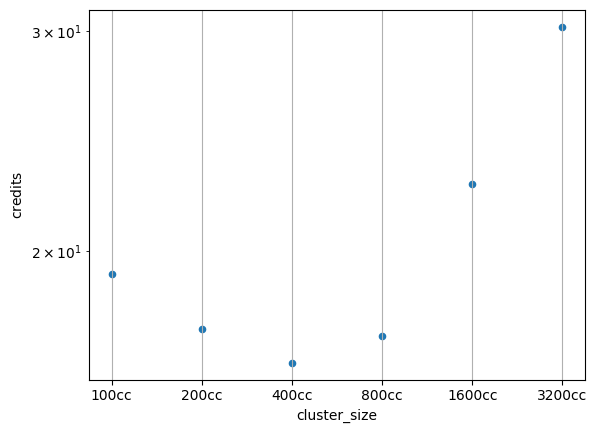

In [19]:
df2 = df[
    (df["mode"] == "strong")
    & (df["scenario"] == "tpcc_mv_sf_10")
    & (df["test_name"] == "create_materialize_view")
]
df2.plot(
    kind="scatter",
    x="cluster_size",
    y="credit_time",
    ylabel="$\\text{credits}$",
    logy=True,
    grid=True,
)
df2

# Peeks

In [20]:
df2 = (
    df.query('category == "peek_serving"')
    .pivot_table(
        index=["scenario_name", "credits_per_h"],
        columns=["category", "test_name", "mode"],
        values=["time_ms"],
        aggfunc="min",
    )
    .sort_index(axis=1)
)
df2

time_ms                                  \
category                     peek_serving                                   
test_name                   index_restart        peek_index_key_fast_path   
mode                               strong   weak                   strong   
scenario_name credits_per_h                                                 
auction       1.0                   270.0  278.0                    104.0   
              2.0                   274.0  292.0                    105.0   
              4.0                   269.0  272.0                    105.0   
              8.0                   268.0  276.0                    105.0   
              16.0                  279.0  274.0                    105.0   
              32.0                  285.0  267.0                    105.0   
tpcc_mv_sf    1.0                     NaN    NaN                      NaN   
              2.0                     NaN    NaN                      NaN   
              4.0                     NaN    NaN                      NaN   
              8.0                     NaN    NaN                      NaN   
              16.0                    NaN    NaN                      NaN   
              32.0                    NaN    NaN                      NaN   
tpcc_sf       1.0                     NaN    NaN                    107.0   
              2.0                     NaN    NaN                    107.0   
              4.0                     NaN    NaN                    107.0   
              8.0                     NaN    NaN                    107.0   
              16.0                    NaN    NaN                    106.0   
              32.0                    NaN    NaN                    106.0   

                                                                    \
category                                                             
test_name                          peek_index_key_slow_path          
mode                          weak                   strong   weak   
scenario_name credits_per_h                                          
auction       1.0            104.0                    106.0  107.0   
              2.0            105.0                    107.0  107.0   
              4.0            105.0                    107.0  107.0   
              8.0            105.0                    107.0  107.0   
              16.0           104.0                    106.0  106.0   
              32.0           104.0                    107.0  107.0   
tpcc_mv_sf    1.0              NaN                      NaN    NaN   
              2.0              NaN                      NaN    NaN   
              4.0              NaN                      NaN    NaN   
              8.0              NaN                      NaN    NaN   
              16.0             NaN                      NaN    NaN   
              32.0             NaN                      NaN    NaN   
tpcc_sf       1.0              NaN                      NaN    NaN   
              2.0              NaN                      NaN    NaN   
              4.0              NaN                      NaN    NaN   
              8.0              NaN                      NaN    NaN   
              16.0             NaN                      NaN    NaN   
              32.0             NaN                      NaN    NaN   

                                                                  \
category                                                           
test_name                   peek_index_non_key_fast_path           
mode                                              strong    weak   
scenario_name credits_per_h                                        
auction       1.0                                 8802.0  8752.0   
              2.0                                 4549.0  8326.0   
              4.0                                 2559.0  7882.0   
              8.0                                 1242.0  7720.0   
              16.0                     

# Primitive operators

test_name     bids_max        bids_sum          join       
mode            strong   weak   strong   weak strong   weak
credits_per_h                                              
1.0              20740  20774    18888  19090  10605  10410
2.0              10309  20218     9555  18714   5464  10352
4.0               5491  20495     4881  18480   3117  10939
8.0               2926  21522     2486  18566   1935  12511
16.0              1654  22757     1429  19162   1372  13908
32.0               974  24719      776  19565   1092  17378

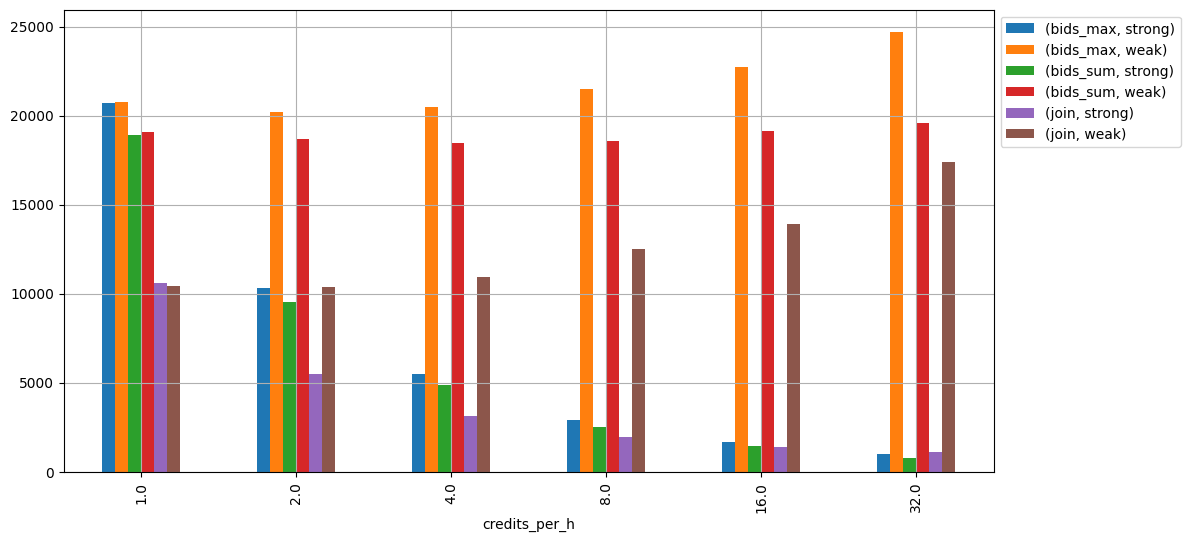

In [21]:
df2 = (
    df.query('category == "primitive_operators"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["category", "test_name", "mode"],
        values=["time_ms"],
    )
    .sort_index(axis=1)
)
df2 = df2.loc[("auction",), ("time_ms", "primitive_operators")].dropna(
    axis=1, how="all"
)
ax = df2.plot(kind="bar", logy=False, figsize=(12, 6))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
df2

## Primitive operators (cost)
Cost for primitive operators, strong scaling, auction workload.

test_name,bids_max,bids_sum,join
mode,strong,strong,strong
credits_per_h,,,
1.0,0.576111,0.524667,0.294583
2.0,0.572722,0.530833,0.303556
4.0,0.610111,0.542333,0.346333
8.0,0.650222,0.552444,0.430000
16.0,0.735111,0.635111,0.609778
32.0,0.865778,0.689778,0.970667


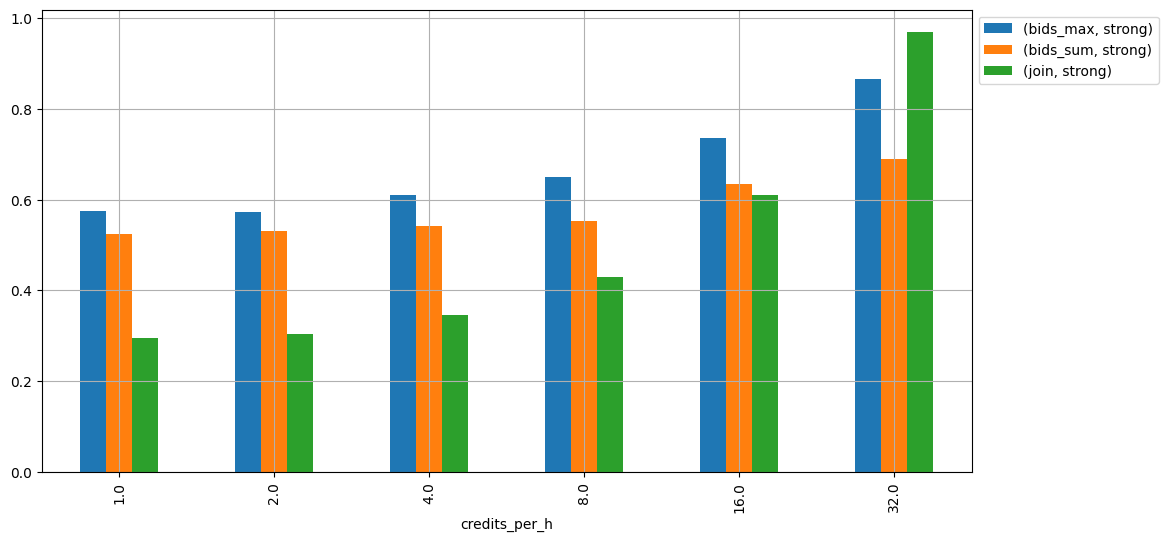

In [22]:
df2 = (
    df.query('category == "primitive_operators" and mode == "strong"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["category", "test_name", "mode"],
        values=["credit_time"],
    )
    .sort_index(axis=1)
)
df2 = df2.loc[("auction",), ("credit_time", "primitive_operators")].dropna(
    axis=1, how="all"
)
ax = df2.plot(kind="bar", logy=False, figsize=(12, 6))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
df2

# Throughput

In [38]:
df2 = (
    df.query('category != "peek_serving"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["mode", "category", "test_name"],
        values=["throughput_mb_per_s"],
    )
    .sort_index(axis=1)
)
df2

throughput_mb_per_s                           \
mode                                       strong                            
category                    arrangement_formation                            
test_name                            create_index create_index_foreign_key   
scenario_name credits_per_h                                                  
auction       1.0                             NaN                34.252994   
              2.0                             NaN                68.250252   
              4.0                             NaN               135.897639   
              8.0                             NaN               263.435226   
              16.0                            NaN               470.462194   
              32.0                            NaN               807.526854   
tpcc_mv_sf    1.0                             NaN                      NaN   
              2.0                             NaN                      NaN   
              4.0                             NaN                      NaN   
              8.0                             NaN                      NaN   
              16.0                            NaN                      NaN   
              32.0                            NaN                      NaN   
tpcc_sf       1.0                       38.473358                      NaN   
              2.0                       72.888348                      NaN   
              4.0                      123.671680                      NaN   
              8.0                      245.654122                      NaN   
              16.0                     306.735624                      NaN   
              32.0                     457.491003                      NaN   

                                                                    \
mode                                                                 
category                                                             
test_name                   create_index_primary_key index_restart   
scenario_name credits_per_h                                          
auction       1.0                          35.751458           NaN   
              2.0                          56.588350           NaN   
              4.0                          85.884295           NaN   
              8.0                         134.213966           NaN   
              16.0                        147.951629           NaN   
              32.0                        244.871935           NaN   
tpcc_mv_sf    1.0                                NaN           NaN   
              2.0                                NaN           NaN   
              4.0                                NaN           NaN   
              8.0                                NaN           NaN   
              16.0                               NaN           NaN   
              32.0                               NaN           NaN   
tpcc_sf       1.0                                NaN     37.134039   
              2.0                                NaN     66.414984   
              4.0                                NaN    130.516655   
              8.0                                NaN    198.993553   
              16.0                               NaN    286.085819   
              32.0                               NaN    236.985718   

                                                                \
mode                                                             
category                       composite_operators               
test_name                   bids_count_max_sum_min    join_max   
scenario_name credits_per_h                                      
auction       1.0                         9.560586   24.128134   
              2.0                        17.717804   44.618570   
              4.0                        34.490765   80.219648   
              8.0                        65.479473  129.949538   
              16.0            

## MiB/s

### Auction

mode                            strong                           \
category         arrangement_formation                            
test_name     create_index_foreign_key create_index_primary_key   
credits_per_h                                                     
1.0                          34.252994                35.751458   
2.0                          68.250252                56.588350   
4.0                         135.897639                85.884295   
8.0                         263.435226               134.213966   
16.0                        470.462194               147.951629   
32.0                        807.526854               244.871935   

mode                                                                  \
category         composite_operators             primitive_operators   
test_name     bids_count_max_sum_min    join_max            bids_max   
credits_per_h                                                          
1.0                         9.560586   24.128134           67.432322   
2.0                        17.717804   44.618570          135.572955   
4.0                        34.490765   80.219648          254.335816   
8.0                        65.479473  129.949538          476.354555   
16.0                      113.695480  193.657856          839.272252   
32.0                      204.916489  246.102542         1425.038728   

mode                                                        weak  \
category                                   arrangement_formation   
test_name         bids_sum         join create_index_foreign_key   
credits_per_h                                                      
1.0              74.061661   132.124820                33.893629   
2.0             146.286526   256.027619                65.727065   
4.0             286.143225   448.266751               125.107109   
8.0             560.685635   720.575313               238.005383   
16.0            971.451889  1011.925070               438.672709   
32.0           1788.699363  1271.201630               783.200786   

mode                                                                       \
category                                  composite_operators               
test_name     create_index_primary_key bids_count_max_sum_min    join_max   
credits_per_h                                                               
1.0                          33.159000               9.398664   23.702466   
2.0                          60.392060              20.492219   40.271809   
4.0                         111.719583              43.836641   69.884686   
8.0                         199.388272              89.676038  113.067971   
16.0                        320.668482             167.714980  161.118314   
32.0                        492.309065             307.298717  191.944253   

mode                                                         
category      primitive_operators                            
test_name                bids_max     bids_sum         join  
credits_per_h                                                
1.0                     67.333434    73.286202   134.606837  
2.0                    132.035520   142.665490   258.084587  
4.0                    253.234235   280.860515   474.651852  
8.0                    475.399522   551.101841   817.970625  
16.0                   892.642799  1060.125639  1460.739716  
32.0                  1637.166096  2068.459545  2328.891140

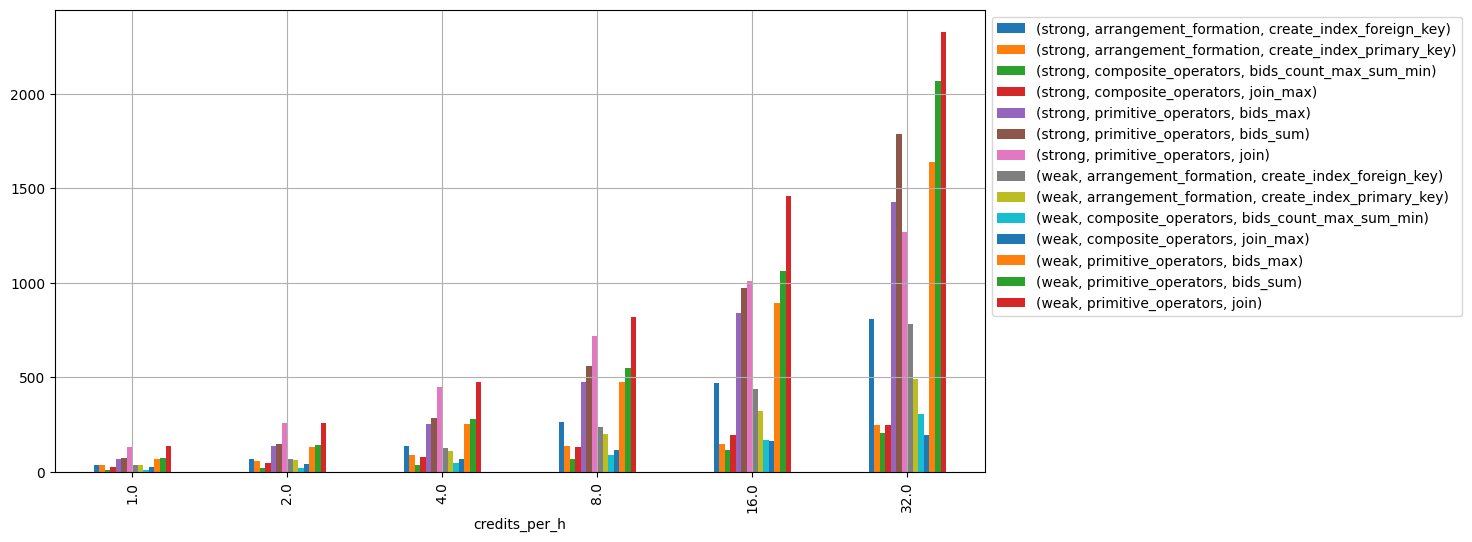

In [39]:
df3 = df2.loc[("auction",), ("throughput_mb_per_s",)].dropna(axis=1, how="all")
ax = df3.plot(kind="bar", logy=False, figsize=(12, 6))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
df3

## MiB/s per worker

In [40]:
df2 = (
    df.query('category != "peek_serving"')
    .pivot(
        index=["scenario_name", "credits_per_h"],
        columns=["mode", "category", "test_name"],
        values=["throughput_mb_per_s_worker"],
    )
    .sort_index(axis=1)
)
df2

throughput_mb_per_s_worker  \
mode                                            strong   
category                         arrangement_formation   
test_name                                 create_index   
scenario_name credits_per_h                              
auction       1.0                                  NaN   
              2.0                                  NaN   
              4.0                                  NaN   
              8.0                                  NaN   
              16.0                                 NaN   
              32.0                                 NaN   
tpcc_mv_sf    1.0                                  NaN   
              2.0                                  NaN   
              4.0                                  NaN   
              8.0                                  NaN   
              16.0                                 NaN   
              32.0                                 NaN   
tpcc_sf       1.0                            19.236679   
              2.0                            18.222087   
              4.0                            15.458960   
              8.0                            15.353383   
              16.0                            9.894698   
              32.0                            7.378887   

                                                                               \
mode                                                                            
category                                                                        
test_name                   create_index_foreign_key create_index_primary_key   
scenario_name credits_per_h                                                     
auction       1.0                          17.126497                17.875729   
              2.0                          17.062563                14.147087   
              4.0                          16.987205                10.735537   
              8.0                          16.464702                 8.388373   
              16.0                         15.176200                 4.772633   
              32.0                         13.024627                 3.949547   
tpcc_mv_sf    1.0                                NaN                      NaN   
              2.0                                NaN                      NaN   
              4.0                                NaN                      NaN   
              8.0                                NaN                      NaN   
              16.0                               NaN                      NaN   
              32.0                               NaN                      NaN   
tpcc_sf       1.0                                NaN                      NaN   
              2.0                                NaN                      NaN   
              4.0                                NaN                      NaN   
              8.0                                NaN                      NaN   
              16.0                               NaN                      NaN   
              32.0                               NaN                      NaN   

                                                                             \
mode                                                                          
category                                     composite_operators              
test_name                   index_restart bids_count_max_sum_min   join_max   
scenario_name credits_per_h                                                   
auction       1.0                     NaN               4.780293  12.064067   
              2.0                     NaN               4.429451  11.154642   
              4.0                     NaN               4.311346  10.027456   
              8.0                     NaN               4.092467   8.121846   
              16.0                    NaN               3.667596   6.247028   
              32.0                    N

mode                            strong                           \
category         arrangement_formation                            
test_name     create_index_foreign_key create_index_primary_key   
credits_per_h                                                     
1.0                          17.126497                17.875729   
2.0                          17.062563                14.147087   
4.0                          16.987205                10.735537   
8.0                          16.464702                 8.388373   
16.0                         15.176200                 4.772633   
32.0                         13.024627                 3.949547   

mode                                                                 \
category         composite_operators            primitive_operators   
test_name     bids_count_max_sum_min   join_max            bids_max   
credits_per_h                                                         
1.0                         4.780293  12.064067           33.716161   
2.0                         4.429451  11.154642           33.893239   
4.0                         4.311346  10.027456           31.791977   
8.0                         4.092467   8.121846           29.772160   
16.0                        3.667596   6.247028           27.073298   
32.0                        3.305105   3.969396           22.984496   

mode                                                    weak  \
category                               arrangement_formation   
test_name       bids_sum       join create_index_foreign_key   
credits_per_h                                                  
1.0            37.030830  66.062410                16.946814   
2.0            36.571631  64.006905                16.431766   
4.0            35.767903  56.033344                15.638389   
8.0            35.042852  45.035957                14.875336   
16.0           31.337158  32.642744                14.150733   
32.0           28.849990  20.503252                12.632271   

mode                                                                      \
category                                  composite_operators              
test_name     create_index_primary_key bids_count_max_sum_min   join_max   
credits_per_h                                                              
1.0                          16.579500               4.699332  11.851233   
2.0                          15.098015               5.123055  10.067952   
4.0                          13.964948               5.479580   8.735586   
8.0                          12.461767               5.604752   7.066748   
16.0                         10.344145               5.410161   5.197365   
32.0                          7.940469               4.956431   3.095875   

mode                                                     
category      primitive_operators                        
test_name                bids_max   bids_sum       join  
credits_per_h                                            
1.0                     33.666717  36.643101  67.303418  
2.0                     33.008880  35.666373  64.521147  
4.0                     31.654279  35.107564  59.331481  
8.0                     29.712470  34.443865  51.123164  
16.0                    28.794929  34.197601  47.120636  
32.0                    26.405905  33.362251  37.562760

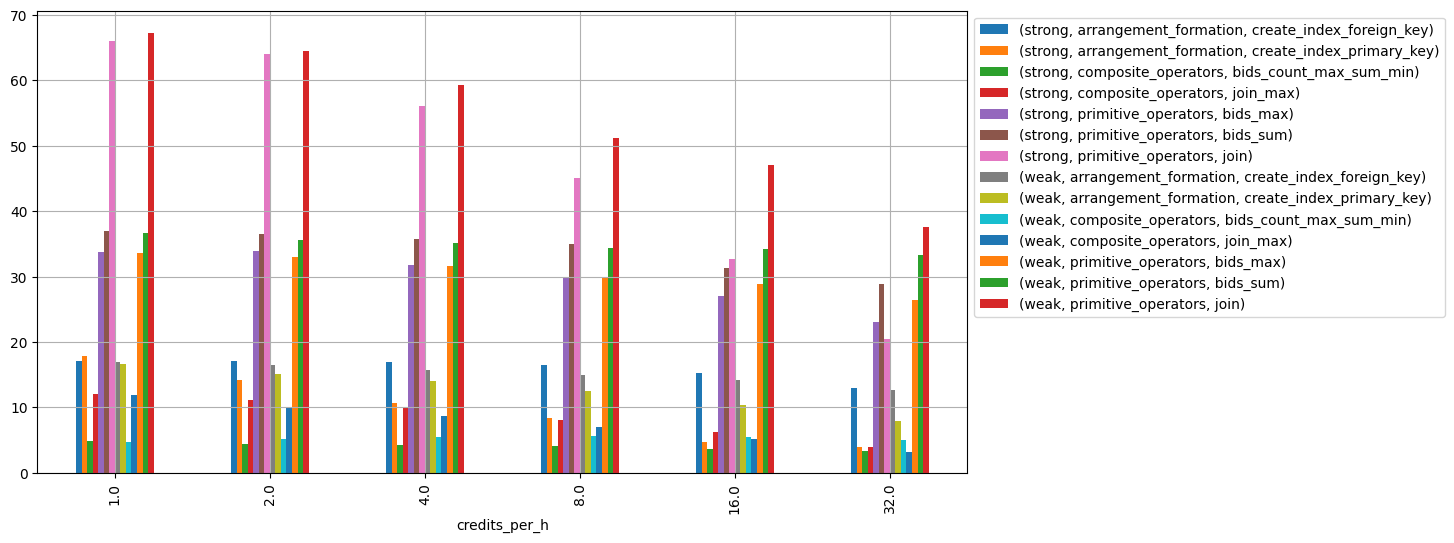

In [42]:
df3 = df2.loc[("auction",), ("throughput_mb_per_s_worker",)].dropna(axis=1, how="all")
ax = df3.plot(kind="bar", logy=False, figsize=(12, 6))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
df3